In [ ]:
# %%

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import GridSearchCV

import scipy.stats as stats

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "..")))

import importlib
import preprocessing.pipeline
importlib.reload(preprocessing.pipeline)
from preprocessing.pipeline import get_preprocessor

In [ ]:
# %%

# === Import data ===
train = pd.read_csv("../data/train.csv")
X_test = pd.read_csv("../data/test.csv")

X_train = train.drop("SalePrice", axis=1)
y_train = train["SalePrice"]

In [ ]:
# %%

# === Build preprocessing + modeling pipeline ===
# Define RMSE scorer
rmse_scorer = make_scorer(
  lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
  greater_is_better=False
)

# Update model_pipeline
model_pipeline = Pipeline([
  ("preprocessor", get_preprocessor()),
  ("model", TransformedTargetRegressor(
    regressor=HuberRegressor(max_iter=1000, epsilon=1.5),
    func=np.log1p,
    inverse_func=np.expm1
  ))
])

# Define parameter grid for HuberRegressor inside the TransformedTargetRegressor
param_grid = {
    'model__regressor__alpha': [1e-5], # 1e-4, 1e-3
    'model__regressor__epsilon': [1.75], # 1.2, 1.35, 1.5
    'model__regressor__max_iter': [1000] # 500, 2000
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Replace model_pipeline with best estimator
model_pipeline = grid_search.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/andrewjowe/opt/anaconda3/envs/STA160/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andrewjowe/opt/anaconda3/envs/STA160/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andrewjowe/opt/anaconda3/envs/STA160/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converg

In [ ]:
# %%

# === Results from CV ===
print(f"Best hyperparameters: {grid_search.best_params_}")

Best hyperparameters: {'model__regressor__alpha': 1e-05, 'model__regressor__epsilon': 1.75, 'model__regressor__max_iter': 1000}


In [ ]:
# %%

# === Fit on full training data ===
model_pipeline.fit(X_train, y_train)

/Users/andrewjowe/opt/anaconda3/envs/STA160/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessing',
                                  Pipeline(steps=[('drop_id',
                                                   ColumnDropper(columns_to_drop=['Id'])),
                                                  ('cat_na_fill',
                                                   CategoricalNaFiller(excluded_cols=['GarageYrBlt'])),
                                                  ('num_na_fill',
                                                   NumericalNaFiller(excluded_cols=['LotFrontage'])),
                                                  ('garage_bin',
                                                   GarageYrBltBinner()),
                                                  ('skewed_transform',
                                                   SkewedFeatureTransformer())])),
                                 ('transformer', OneHotEncoderScaler()),
                                 ('lotfrontage_fill', LotFrontageFiller())])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=HuberRegressor(alpha=1e-05,
                                                                     epsilon=1.75,
                                                                     max_iter=1000)))])

In [ ]:
# %%

# === Evaluate on training data ===
y_train_pred = model_pipeline.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Train R² Score: {train_r2:.4f}")

Train RMSE: 18982.29
Train R² Score: 0.9429


In [ ]:
# %%

# === Compare training vs validation RMSE for overfitting analysis ===
val_preds_cv = cross_val_predict(model_pipeline, X_train, y_train, cv=KFold(n_splits=10, shuffle=True, random_state=42))
val_rmse = np.sqrt(mean_squared_error(y_train, val_preds_cv))
val_r2 = r2_score(y_train, val_preds_cv)

/Users/andrewjowe/opt/anaconda3/envs/STA160/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andrewjowe/opt/anaconda3/envs/STA160/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andrewjowe/opt/anaconda3/envs/STA160/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converg

In [ ]:
# %%

# === Output CV ===
print(f"Validation RMSE (CV): {val_rmse:.2f}")
print(f"Validation R² Score (CV): {val_r2:.4f}")

Validation RMSE (CV): 50672.20
Validation R² Score (CV): 0.5929


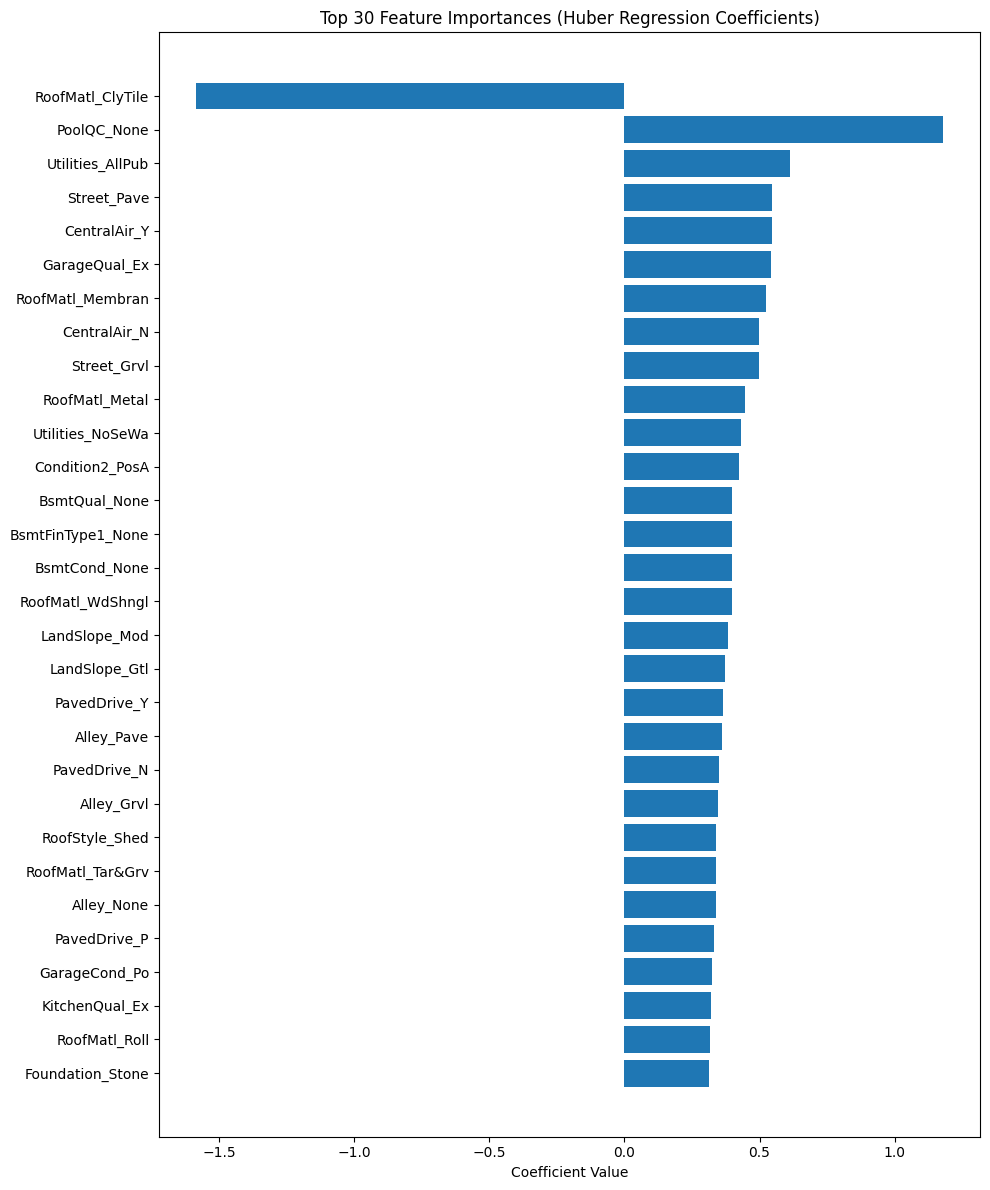

In [ ]:
# %%

# === Feature Importances (Linear Model Coefficients) ===
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
coefs = model_pipeline.named_steps['model'].regressor_.coef_

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
}).sort_values(by='Coefficient', key=np.abs, ascending=False)

plt.figure(figsize=(10, 12))
plt.barh(coef_df['Feature'][:30][::-1], coef_df['Coefficient'][:30][::-1])  # Top 30
plt.xlabel("Coefficient Value")
plt.title("Top 30 Feature Importances (Huber Regression Coefficients)")
plt.tight_layout()
plt.savefig("../fig/hr/feature_importances.png")
plt.show()

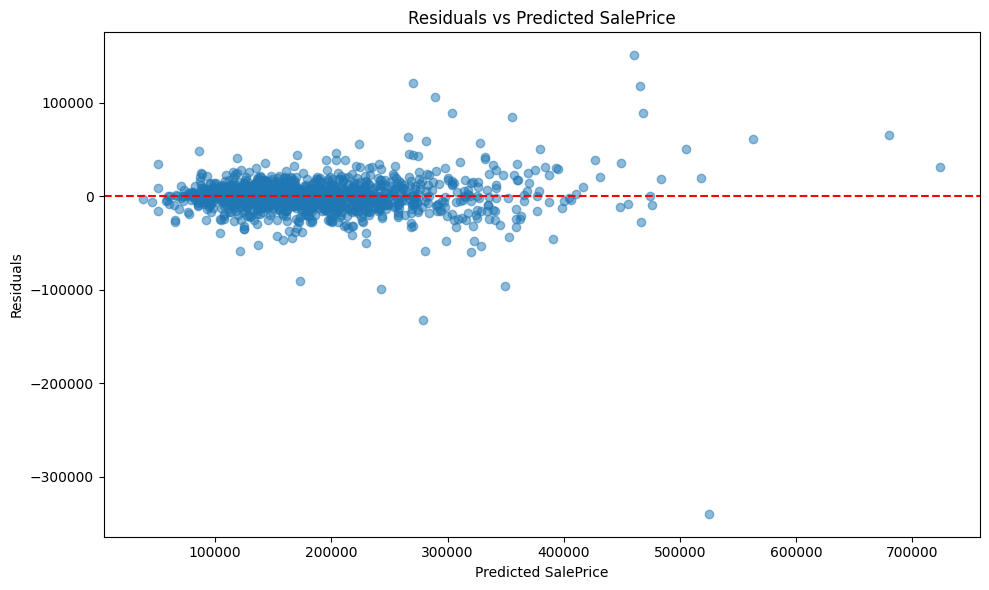

In [ ]:
# %%

# === Plot Residuals ===
residuals = y_train - y_train_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_train_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted SalePrice")
plt.tight_layout()
plt.savefig("../fig/hr/residuals_vs_predicted.png")
plt.show()

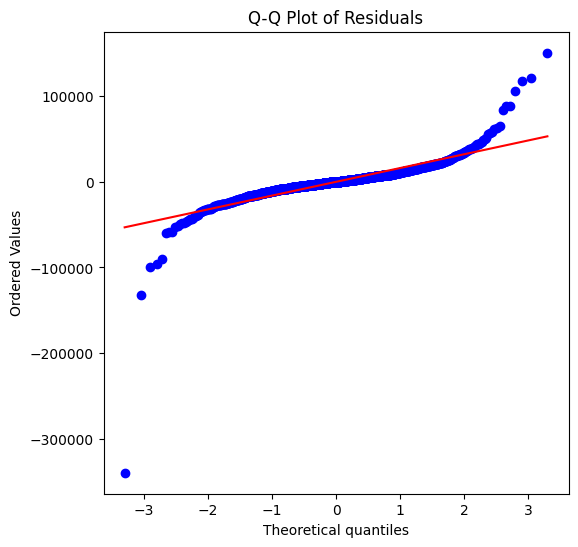

In [ ]:
# %%

# === Check normality of residuals
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.savefig("../fig/hr/qq_plot_residuals.png")
plt.show()

In [ ]:
# %%

# === Predict on test data ===
y_test_pred = model_pipeline.predict(X_test)

In [ ]:
# %%

# === Wrap in DataFrame ===
submission = pd.DataFrame({
  "Id": X_test["Id"],  # assuming 'Id' is in test data
  "SalePrice": y_test_pred
})

submission.head()

,Id,SalePrice
0,1461,124283.434208
1,1462,168074.369607
2,1463,192199.047781
3,1464,200278.128916
4,1465,195884.455026


In [ ]:
# %%

# === Save in submission file ===
submission.to_csv("../data/submission_hr.csv", index=False)